In [56]:
import tensorflow as tf
from tensorflow.keras import layers
from fractions import Fraction
import glob
import music21
from music21 import converter, instrument, note, chord, stream
import numpy as np
from keras.callbacks import ModelCheckpoint

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
# tf.config.experimental.set_virtual_device_configuration(
#     gpus[0],
#     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=)]
# )

notes = []
offsets = []
durations = []

for file in glob.glob("TheFatRat/*.mid"):
    midi = converter.parse(file)
    notes_to_parse = midi.flat.notes
    prev = notes_to_parse[0]
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))
        offsets.append(element.offset - prev.offset)
        durations.append(element.duration.quarterLength)
        prev = element

In [57]:
sequenceLen = 100
pitchnames = sorted(set(item for item in notes))
durationNames = sorted(set(item for item in durations))
offsetNames = sorted(set(item for item in offsets))

noteToInt = dict((note, number) for number, note in enumerate(pitchnames))
durationToInt = dict((length, number) for number, length in enumerate(durationNames))
offsetToInt = dict((length, number) for number, length in enumerate(offsetNames))

notesOneHot = list(map(noteToInt.get, notes))
notesOneHot = tf.keras.utils.to_categorical(notesOneHot)

offsetsOneHot = list(map(offsetToInt.get, offsets))
offsetsOneHot = tf.keras.utils.to_categorical(offsetsOneHot)

durationsOneHot = list(map(durationToInt.get, durations))
durationsOneHot = tf.keras.utils.to_categorical(durationsOneHot)

inputNotes = []
outputNotes = []

inputOffsets = []
outputOffsets = []

inputDurations = []
outputDurations = []

for i in range(len(notes)-sequenceLen):
    inputNotes.append(notesOneHot[i:i+sequenceLen])
    outputNotes.append(notesOneHot[i+sequenceLen])

    inputOffsets.append(offsetsOneHot[i:i+sequenceLen])
    outputOffsets.append(offsetsOneHot[i+sequenceLen])

    inputDurations.append(durationsOneHot[i:i+sequenceLen])
    outputDurations.append(durationsOneHot[i+sequenceLen])

# inputNotes = tf.keras.utils.to_categorical(inputNotes)
# outputNotes = tf.keras.utils.to_categorical(outputNotes)

# inputOffsets = tf.keras.utils.to_categorical(inputOffsets)
# outputOffsets = tf.keras.utils.to_categorical(outputOffsets)

# inputDurations = tf.keras.utils.to_categorical(inputDurations)
# outputDurations = tf.keras.utils.to_categorical(outputDurations)

inputNotes = np.array(inputNotes)
outputNotes = np.array(outputNotes)
inputOffsets = np.array(inputOffsets)
outputOffsets = np.array(outputOffsets)
inputDurations = np.array(inputDurations)
outputDurations = np.array(outputDurations)

numVocab = inputNotes.shape[-1]
numDurations = inputDurations.shape[-1]
numOffsets = inputOffsets.shape[-1]

print(inputOffsets.shape, outputOffsets.shape)

(2676, 100, 37) (2676, 37)


In [58]:
with tf.device('/device:GPU:0'):
    notesInputLayer = layers.Input(shape=(inputNotes.shape[1], inputNotes.shape[2]))
    notesInput = layers.LSTM(units=256, input_shape=(inputNotes.shape[1], inputNotes.shape[2]), return_sequences=True)(notesInputLayer)
    notesInput = layers.Dropout(0.2)(notesInput)

    offsetsInputLayer = layers.Input(shape=(inputOffsets.shape[1], inputOffsets.shape[2]))
    offsetsInput = layers.LSTM(units=256, input_shape=(inputOffsets.shape[1], inputOffsets.shape[2]), return_sequences=True)(offsetsInputLayer)
    offsetsInput = layers.Dropout(0.2)(offsetsInput)

    durationsInputLayer = layers.Input(shape=(inputDurations.shape[1], inputDurations.shape[2]))
    durationsInput = layers.LSTM(units=256, input_shape=(inputDurations.shape[1], inputDurations.shape[2]), return_sequences=True)(durationsInputLayer)
    durationsInput = layers.Dropout(0.2)(durationsInput)

    inputs = layers.concatenate([notesInput, offsetsInput, durationsInput])

    x = layers.LSTM(512, return_sequences=True)(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.LSTM(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)

    notesOutput = layers.Dense(128, activation='relu')(x)
    notesOutput = layers.BatchNormalization()(notesOutput)
    notesOutput = layers.Dropout(0.3)(notesOutput)
    notesOutput = layers.Dense(numVocab, activation='softmax', name="Note")(notesOutput)

    offsetsOutput = layers.Dense(128, activation='relu')(x)
    offsetsOutput = layers.BatchNormalization()(offsetsOutput)
    offsetsOutput = layers.Dropout(0.3)(offsetsOutput)
    offsetsOutput = layers.Dense(numOffsets, activation='softmax', name="Offset")(offsetsOutput)

    durationsOutput = layers.Dense(128, activation='relu')(x)
    durationsOutput = layers.BatchNormalization()(durationsOutput)
    durationsOutput = layers.Dropout(0.3)(durationsOutput)
    durationsOutput = layers.Dense(numDurations, activation='softmax', name="Duration")(durationsOutput)

    model = tf.keras.Model(inputs=[notesInputLayer, offsetsInputLayer, durationsInputLayer], outputs=[notesOutput, offsetsOutput, durationsOutput])

    losses = {
        'Note':'categorical_crossentropy',
        'Offset':'categorical_crossentropy',
        'Duration':'categorical_crossentropy'
    }

    model.compile(loss=losses, optimizer='adam')

    filepath = "./Weights/weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"    
    checkpoint = ModelCheckpoint(
        filepath, 
        monitor='loss', 
        verbose=0,        
        save_best_only=True,
        mode='min'
    )
    callbacks_list = [checkpoint]

    history = model.fit([inputNotes, inputOffsets, inputDurations], [outputNotes, outputOffsets, outputDurations], epochs=200, batch_size=64, callbacks=callbacks_list)

Epoch 1/200
42/42 [==============================] - 8s 62ms/step - loss: 10.1560 - Note_loss: 4.5833 - Offset_loss: 3.3480 - Duration_loss: 2.2247
Epoch 2/200
42/42 [==============================] - 3s 60ms/step - loss: 8.2249 - Note_loss: 3.9980 - Offset_loss: 2.4463 - Duration_loss: 1.7807
Epoch 3/200
42/42 [==============================] - 3s 60ms/step - loss: 7.4379 - Note_loss: 3.7792 - Offset_loss: 2.1424 - Duration_loss: 1.5162
Epoch 4/200
42/42 [==============================] - 3s 60ms/step - loss: 6.7540 - Note_loss: 3.6200 - Offset_loss: 1.8404 - Duration_loss: 1.2936
Epoch 5/200
42/42 [==============================] - 3s 60ms/step - loss: 6.2351 - Note_loss: 3.4595 - Offset_loss: 1.6536 - Duration_loss: 1.1221
Epoch 6/200
42/42 [==============================] - 3s 62ms/step - loss: 5.7648 - Note_loss: 3.3573 - Offset_loss: 1.4175 - Duration_loss: 0.9900
Epoch 7/200
42/42 [==============================] - 3s 61ms/step - loss: 5.3791 - Note_loss: 3.1790 - Offset_loss: 1

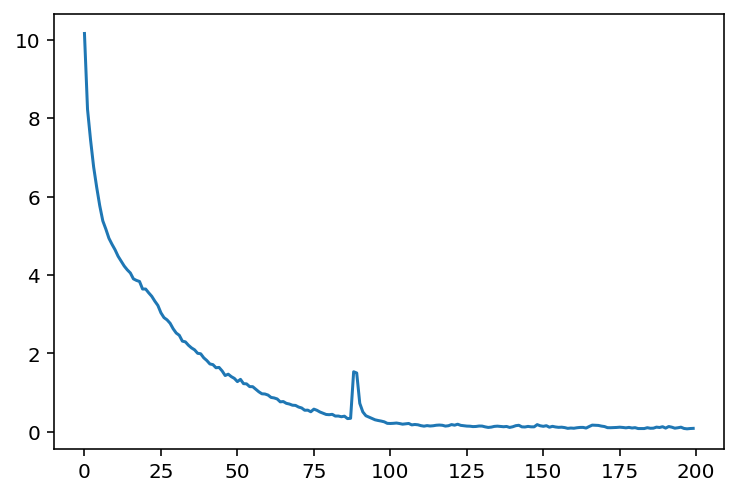

In [59]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.show()

In [60]:
start1 = np.random.randint(0, len(inputNotes)-1)
start2 = np.random.randint(0, len(inputOffsets)-1)
start3 = np.random.randint(0, len(inputDurations)-1)
intToNote = dict((number, note) for number, note in enumerate(pitchnames))
intToOffset = dict((number, note) for number, note in enumerate(offsetNames))
intToDuration = dict((number, note) for number, note in enumerate(durationNames))

notesPattern = inputNotes[start1].tolist()
offsetsPattern = inputOffsets[start2].tolist()
durationsPattern = inputDurations[start3].tolist()

predictionNotesOut = []
predictionOffsetsOut = []
predictionDurationsOut = []

for i in range(500):
    predictionNotesIn = np.reshape(np.array(notesPattern), (1, len(notesPattern), numVocab))
    predictionOffsetsIn = np.reshape(np.array(offsetsPattern), (1, len(offsetsPattern), numOffsets))
    predictionDurationsIn = np.reshape(np.array(durationsPattern), (1, len(durationsPattern), numDurations))
    prediction = model.predict([predictionNotesIn, predictionOffsetsIn, predictionDurationsIn], verbose=0)
    
    predictionNote = prediction[0][0]
    predictionOffset = prediction[1][0]
    predictionDuration = prediction[2][0]

    noteIndex = np.argmax(predictionNote)
    max = predictionNote.max()
    predictionNote = np.where(predictionNote == max, 1., 0.)
    noteResult = intToNote[noteIndex]

    offsetIndex = np.argmax(predictionOffset)
    max = predictionOffset.max()
    predictionOffset = np.where(predictionOffset == max, 1., 0.)
    offsetResult = intToOffset[offsetIndex]
    
    durationIndex = np.argmax(predictionDuration)
    max = predictionDuration.max()
    predictionDuration = np.where(predictionDuration == max, 1., 0.)
    durationResult = intToDuration[durationIndex]
    
    predictionNotesOut.append(noteResult)
    predictionOffsetsOut.append(offsetResult)
    predictionDurationsOut.append(durationResult)
    
    notesPattern.append(predictionNote)
    notesPattern = notesPattern[1:len(notesPattern)]
    offsetsPattern.append(predictionOffset)
    offsetsPattern = offsetsPattern[1:len(offsetsPattern)]
    durationsPattern.append(predictionDuration)
    durationsPattern = durationsPattern[1:len(durationsPattern)]


In [61]:
def FloatToQuarter(num):
    values = [2, 1, 1/2, 1/3, 1/4, 1/6, 1/8, 1/16]
    val = min(values, key=lambda x:abs(x-num))
    return val

offset = 0
output_notes = [] # create note and chord objects based on the values generated by the model
i = 0
for pattern in predictionNotesOut:
    offset += predictionOffsetsOut[i]
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        new_chord.duration.quarterLength = FloatToQuarter(predictionDurationsOut[i])
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.duration.quarterLength = FloatToQuarter(predictionDurationsOut[i])
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)    # increase offset each iteration so that notes do not stack
    i += 1


In [62]:
for i in output_notes:
    print(i.duration)

<music21.duration.Duration 0.25>
<music21.duration.Duration 0.25>
<music21.duration.Duration 0.25>
<music21.duration.Duration 0.5>
<music21.duration.Duration 0.5>
<music21.duration.Duration 0.25>
<music21.duration.Duration 0.25>
<music21.duration.Duration 0.25>
<music21.duration.Duration 0.25>
<music21.duration.Duration 0.25>
<music21.duration.Duration 0.25>
<music21.duration.Duration 0.25>
<music21.duration.Duration 0.25>
<music21.duration.Duration 0.5>
<music21.duration.Duration 0.5>
<music21.duration.Duration 0.25>
<music21.duration.Duration 0.25>
<music21.duration.Duration 0.5>
<music21.duration.Duration 0.5>
<music21.duration.Duration 0.25>
<music21.duration.Duration 0.25>
<music21.duration.Duration 0.5>
<music21.duration.Duration 0.5>
<music21.duration.Duration 0.25>
<music21.duration.Duration 0.25>
<music21.duration.Duration 0.25>
<music21.duration.Duration 0.25>
<music21.duration.Duration 0.25>
<music21.duration.Duration 0.25>
<music21.duration.Duration 0.25>
<music21.duration.

In [63]:
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='test_output.mid')

'test_output.mid'